In [ ]:
# TODO: Make all necessary imports.
# !pip install -q tqdm==4.28.1

# !pip install tensorflow_datasets
# !pip install tensorflow_hub
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



In [10]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
tfds.disable_progress_bar()
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
dataset_info
# TODO: Create a training set, a validation set and a test set.
test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

Dataset oxford_flowers102 downloaded and prepared to C:\Users\yisi9\tensorflow_datasets\oxford_flowers102\2.1.1. Subsequent calls will reuse this data.


In [3]:
dataset

{Split('train'): <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 Split('test'): <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 Split('validation'): <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}

In [4]:
# TODO: Get the number of examples in each set from the dataset info.
num_training_examples = 0
num_validation_examples = 0
num_test_examples = 0

for example in training_set:
    num_training_examples += 1

for example in validation_set:
    num_validation_examples += 1

for example in test_set:
    num_test_examples += 1

print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {}'.format(num_validation_examples))
print('Total Number of Test Images: {} \n'.format(num_test_examples))
# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print('Total Number of Classes: {}'.format(num_classes))

Total Number of Training Images: 1020
Total Number of Validation Images: 1020
Total Number of Test Images: 6149 

Total Number of Classes: 102


In [5]:
training_set.take(1)

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

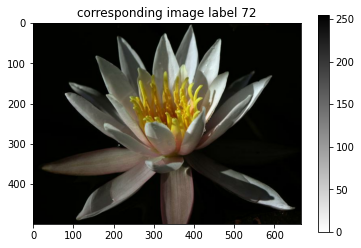

In [6]:
for image, label in training_set.take(1):
  break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

In [8]:
# TODO: Create a pipeline for each set.
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

train_batches = training_set.cache().shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = test_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
# test_batches = test_set.cache().map(format_image)
# batch = test_batches.batch(BATCH_SIZE).prefetch(1) 

In [11]:
# TODO: Build and train your network.
from tensorflow.keras import layers
# Create a Feature Extractor
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))
# Freeze the Pre-Trained Model
feature_extractor.trainable = False
# Attach a classification head
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
print('Is there a GPU Available:', tf.test.is_gpu_available())

Is there a GPU Available: True


In [13]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 20

# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 7.6332 - accuracy: 0.03 - ETA: 0s - loss: 7.3505 - accuracy: 0.01 - ETA: 0s - loss: 7.8917 - accuracy: 0.00 - ETA: 0s - loss: 8.2889 - accuracy: 0.00 - ETA: 0s - loss: 8.5160 - accuracy: 0.00 - ETA: 0s - loss: 8.4756 - accuracy: 0.00 - ETA: 0s - loss: 8.5614 - accuracy: 0.00 - ETA: 0s - loss: 8.4887 - accuracy: 0.00 - ETA: 0s - loss: 8.5332 - accuracy: 0.00 - ETA: 0s - loss: 8.5240 - accuracy: 0.00 - 1s 46ms/step - loss: 8.5240 - accuracy: 0.0078 - val_loss: 7.4054 - val_accuracy: 0.0108
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 7.9766 - accuracy: 0.0000e+ - ETA: 0s - loss: 7.2481 - accuracy: 0.0063   - ETA: 0s - loss: 7.1723 - accuracy: 0.00 - ETA: 0s - loss: 7.2908 - accuracy: 0.00 - ETA: 0s - loss: 7.3591 - accuracy: 0.00 - ETA: 0s - loss: 7.2850 - accuracy: 0.00 - ETA: 0s - loss: 7.2369 - accuracy: 0.00 - ETA: 0s - loss: 7.1908 - accuracy: 0.00 - 1s 31ms/step - loss: 7.1366 - accuracy: 0.0